# Notebook N03 – Haltestellenkarte und mittlere Verspätung (Züge, Schweiz)

Ziel dieses Notebooks:
- Konzentration auf Zugverkehr (PRODUKT_ID = "Zug")
- Aggregation der Verspätung pro Haltestelle (BPUIC + Name)
- Join mit Haltestellen-Koordinaten
- Visualisierung: Punktkarte der Schweiz, eingefärbt nach mittlerer Ankunftsverspätung

In [1]:
# %%
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

pd.set_option("display.max_columns", None)
pd.set_option("display.width", 160)

# Pfad zu eurer Monatsdatei mit BPUIC
data_path = Path("../data/processed/istdata_clean.parquet")
df = pd.read_parquet(data_path)

print(f"Datensatz geladen: {df.shape[0]:,} Zeilen × {df.shape[1]} Spalten")
print(df.columns)
df.head(5)

Datensatz geladen: 65,940,915 Zeilen × 13 Spalten
Index(['BETRIEBSTAG', 'BETREIBER_NAME', 'PRODUKT_ID', 'LINIEN_TEXT', 'HALTESTELLEN_NAME', 'ANKUNFTSZEIT', 'ABFAHRTSZEIT', 'delay_arrival_s',
       'delay_departure_s', 'on_time', 'FAELLT_AUS_TF', 'BPUIC', 'Wochentag'],
      dtype='object')


,BETRIEBSTAG,BETREIBER_NAME,PRODUKT_ID,LINIEN_TEXT,HALTESTELLEN_NAME,ANKUNFTSZEIT,ABFAHRTSZEIT,delay_arrival_s,delay_departure_s,on_time,FAELLT_AUS_TF,BPUIC,Wochentag
0,2025-09-01,DB ZugBus Regionalverkehr Alb-Bodensee,Zug,IR3,Schaffhausen,2025-01-09 05:54:00+00:00,2025-01-09 05:56:00+00:00,114.0,78.0,False,False,8503424,Monday
1,2025-09-01,DB ZugBus Regionalverkehr Alb-Bodensee,Zug,RE3,Schaffhausen,2025-01-09 06:14:00+00:00,2025-01-09 06:16:00+00:00,42.0,1.0,True,False,8503424,Monday
2,2025-09-01,DB ZugBus Regionalverkehr Alb-Bodensee,Zug,IR3,Schaffhausen,2025-01-09 06:58:00+00:00,2025-01-09 07:00:00+00:00,31.0,17.0,True,False,8503424,Monday
3,2025-09-01,DB ZugBus Regionalverkehr Alb-Bodensee,Zug,RE3,Schaffhausen,2025-01-09 06:58:00+00:00,2025-01-09 07:00:00+00:00,18.0,-2.0,True,False,8503424,Monday
4,2025-09-01,DB ZugBus Regionalverkehr Alb-Bodensee,Zug,IR3,Schaffhausen,2025-01-09 07:58:00+00:00,2025-01-09 08:00:00+00:00,83.0,20.0,False,False,8503424,Monday


In [6]:
# Nur Züge
df_trains = df[df["PRODUKT_ID"] == "Zug"].copy()
print(f"Nur Züge: {df_trains.shape[0]:,} Zeilen")

# Verspätungen in Minuten
df_trains["arr_delay_min"] = df_trains["delay_arrival_s"] / 60
df_trains["dep_delay_min"] = df_trains["delay_departure_s"] / 60


# Delta: wie ändert sich die Verspätung an der Station?
df_trains["delta_delay_min"] = df_trains["dep_delay_min"] - df_trains["arr_delay_min"]

df_trains[["HALTESTELLEN_NAME", "BPUIC", "arr_delay_min", "dep_delay_min", "delta_delay_min"]].head(10)

Nur Züge: 4,615,140 Zeilen


,HALTESTELLEN_NAME,BPUIC,arr_delay_min,dep_delay_min,delta_delay_min
0,Schaffhausen,8503424,1.900000,1.300000,-0.600000
1,Schaffhausen,8503424,0.700000,0.016667,-0.683333
2,Schaffhausen,8503424,0.516667,0.283333,-0.233333
3,Schaffhausen,8503424,0.300000,-0.033333,-0.333333
4,Schaffhausen,8503424,1.383333,0.333333,-1.050000
5,Schaffhausen,8503424,3.700000,2.400000,-1.300000
6,Schaffhausen,8503424,4.783333,3.116667,-1.666667
7,Schaffhausen,8503424,0.183333,0.183333,0.000000
8,Schaffhausen,8503424,-0.016667,0.250000,0.266667
9,Schaffhausen,8503424,3.066667,2.233333,-0.833333


In [7]:
# BPUIC konsistent als String
df_trains["BPUIC"] = df_trains["BPUIC"].astype(str)

agg_stations = (
    df_trains
    .groupby(["BPUIC", "HALTESTELLEN_NAME"])
    .agg(
        mean_arr_delay_min=("arr_delay_min", "mean"),
        mean_dep_delay_min=("dep_delay_min", "mean"),
        mean_delta_delay_min=("delta_delay_min", "mean"),
        median_delta_delay_min=("delta_delay_min", "median"),
        n_obs=("delta_delay_min", "size"),
    )
    .reset_index()
)

print("Aggregierte Haltestellen (Kopf):")
print(agg_stations.head(10))

print("\nVerteilung der Beobachtungszahlen pro Haltestelle:")
print(agg_stations["n_obs"].describe())

Aggregierte Haltestellen (Kopf):
     BPUIC     HALTESTELLEN_NAME  mean_arr_delay_min  mean_dep_delay_min  mean_delta_delay_min  median_delta_delay_min  n_obs
0  8002301         Lindau-Reutin             3.00000            8.000000              5.000000                5.000000      1
1  8002307  Kempten (Allgäu) Hbf             1.15000            0.000000             -1.150000               -1.150000      1
2  8002342            Immenstadt             1.00000            0.000000             -1.000000               -1.000000      1
3  8002347           Oberstaufen             2.00000            2.000000              0.000000                0.000000      1
4  8002349   Röthenbach (Allgäu)             3.00000            3.000000              0.000000                0.000000      1
5  8002357           Heimenkirch             4.00000            4.000000              0.000000                0.000000      1
6  8002363               Hergatz             4.00000            3.000000             

In [32]:
MIN_OBS = 5000

agg_filtered = agg_stations[agg_stations["n_obs"] >= MIN_OBS].copy()
print(f"Haltestellen mit mindestens {MIN_OBS} Fahrten: {agg_filtered.shape[0]}")

# Bahnhöfe, die im Mittel am meisten Verspätung ABBauen (delta stark negativ)
best_stations = (
    agg_filtered
    .sort_values("mean_delta_delay_min", ascending=True)  # stärkste Reduktion zuerst
    .head(30)
)

print("Bahnhöfe, die im Mittel am meisten Verspätung abgebaut haben (delta_delay_min < 0):")
print(
    best_stations[["HALTESTELLEN_NAME", "BPUIC", "mean_arr_delay_min", "mean_dep_delay_min", "mean_delta_delay_min", "n_obs"]]
    .to_string(index=False)
)

# Bahnhöfe, die im Mittel am meisten zusätzliche Verspätung erzeugen (delta stark positiv)
worst_stations = (
    agg_filtered
    .sort_values("mean_delta_delay_min", ascending=False)  # stärkste Verschlechterung zuerst
    .head(30)
)

print("\nBahnhöfe, die im Mittel am meisten zusätzliche Verspätung erzeugen (delta_delay_min > 0):")
print(
    worst_stations[["HALTESTELLEN_NAME", "BPUIC", "mean_arr_delay_min", "mean_dep_delay_min", "mean_delta_delay_min", "n_obs"]]
    .to_string(index=False)
)

Haltestellen mit mindestens 5000 Fahrten: 137
Bahnhöfe, die im Mittel am meisten Verspätung abgebaut haben (delta_delay_min < 0):
HALTESTELLEN_NAME   BPUIC  mean_arr_delay_min  mean_dep_delay_min  mean_delta_delay_min  n_obs
       Frauenfeld 8506100            0.864216           -1.618371             -2.482588   6775
          Herisau 8506290            0.453999            0.140564             -0.313435   7664
   Interlaken Ost 8507492            1.444654            1.175591             -0.269063   8290
 Lancy-Pont-Rouge 8516155            1.003242            0.899305             -0.103937   6498
          Zermatt 8501689            1.338570            1.258695             -0.079875   5051
        Zürich HB 8503000            1.158961            1.158681             -0.000280  66865
           Coppet 8501023            1.023582            1.035928              0.012346   6917
     Schaffhausen 8503424            1.358633            1.405974              0.047341  16875
          Locar

In [33]:
from pathlib import Path

export_cols = [
    "BPUIC",
    "HALTESTELLEN_NAME",
    "mean_arr_delay_min",
    "mean_dep_delay_min",
    "mean_delta_delay_min",
    "median_delta_delay_min",
    "n_obs",
]

out_path = Path("../data/processed/station_delta_delays_2025-09_minObs200.csv")
agg_filtered[export_cols].to_csv(out_path, index=False)

print("Aggregierte Stationskennzahlen gespeichert unter:")
print(out_path)

Aggregierte Stationskennzahlen gespeichert unter:
../data/processed/station_delta_delays_2025-09_minObs200.csv


In [34]:
from pathlib import Path
import pandas as pd

stops_path = Path("../data/external/dienststellen.csv")

# Wichtig: sep=';' setzen, damit das Komma in der Geoposition nicht als Spaltentrenner verwendet wird
stops = pd.read_csv(stops_path, sep=";", dtype=str)

print(stops.columns)
stops.head()

Index(['lod', 'Geoposition', '﻿numberShort', 'uicCountryCode', 'sloid', 'number', 'validFrom', 'validTo', 'designationOfficial', 'designationLong',
       'abbreviation', 'operatingPoint', 'operatingPointWithTimetable', 'stopPoint', 'stopPointType', 'freightServicePoint', 'trafficPoint', 'borderPoint',
       'hasGeolocation', 'isoCountryCode', 'cantonName', 'cantonFsoNumber', 'cantonAbbreviation', 'districtName', 'districtFsoNumber', 'municipalityName',
       'fsoNumber', 'localityName', 'operatingPointType', 'operatingPointTechnicalTimetableType', 'meansOfTransport', 'categories',
       'operatingPointTrafficPointType', 'operatingPointRouteNetwork', 'operatingPointKilometer', 'operatingPointKilometerMasterNumber',
       'sortCodeOfDestinationStation', 'businessOrganisation', 'businessOrganisationNumber', 'businessOrganisationAbbreviationDe',
       'businessOrganisationAbbreviationFr', 'businessOrganisationDescriptionDe', 'businessOrganisationDescriptionFr', 'fotComment', 'height'

,lod,Geoposition,﻿numberShort,uicCountryCode,sloid,number,validFrom,validTo,designationOfficial,designationLong,abbreviation,operatingPoint,operatingPointWithTimetable,stopPoint,stopPointType,freightServicePoint,trafficPoint,borderPoint,hasGeolocation,isoCountryCode,cantonName,cantonFsoNumber,cantonAbbreviation,districtName,districtFsoNumber,municipalityName,fsoNumber,localityName,operatingPointType,operatingPointTechnicalTimetableType,meansOfTransport,categories,operatingPointTrafficPointType,operatingPointRouteNetwork,operatingPointKilometer,operatingPointKilometerMasterNumber,sortCodeOfDestinationStation,businessOrganisation,businessOrganisationNumber,businessOrganisationAbbreviationDe,businessOrganisationAbbreviationFr,businessOrganisationDescriptionDe,businessOrganisationDescriptionFr,fotComment,height,creationDate,editionDate
0,http://lod.opentransportdata.swiss/didok/1110530,"48.469860010403906, 8.49968000801024",10530,11,ch:1:sloid:1110530,1110530,2022-12-11,9999-12-31,"Dornstetten, Hauptstrasse",NaN,NaN,true,true,true,NaN,false,true,false,true,DE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,BUS,NaN,NaN,false,false,NaN,NaN,ch:1:sboid:101257,9988,INFOPLUS,INFOPLUS,Fiktive GO für Infoplus,Fiktive GO für Infoplus,NaN,0.0,2023-04-28T06:44:26+02:00,2024-04-08T11:26:06+02:00
1,http://lod.opentransportdata.swiss/didok/1110577,"52.281669008914854, 10.576396007454766",10577,11,ch:1:sloid:1110577,1110577,2022-12-11,9999-12-31,"Braunschweig, Petzvalstrasse",NaN,NaN,true,true,true,NaN,false,true,false,true,DE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,BUS,NaN,NaN,false,false,NaN,NaN,ch:1:sboid:101257,9988,INFOPLUS,INFOPLUS,Fiktive GO für Infoplus,Fiktive GO für Infoplus,NaN,0.0,2023-06-06T10:32:35+02:00,2024-04-08T11:26:06+02:00
2,http://lod.opentransportdata.swiss/didok/1110609,"53.698358007861174, 10.741624006255964",10609,11,ch:1:sloid:1110609,1110609,2022-12-11,9999-12-31,"Ratzeburg, Bahnhof",NaN,NaN,true,true,true,NaN,false,true,false,true,DE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,BUS,NaN,NaN,false,false,NaN,NaN,ch:1:sboid:101257,9988,INFOPLUS,INFOPLUS,Fiktive GO für Infoplus,Fiktive GO für Infoplus,NaN,0.0,2023-06-27T10:01:59+02:00,2024-04-08T11:26:06+02:00
3,http://lod.opentransportdata.swiss/didok/1110611,"52.58176120729621, 13.579174008055386",10611,11,ch:1:sloid:1110611,1110611,2022-12-11,9999-12-31,"Ahrensfelde, Kirschenallee",NaN,NaN,true,true,true,NaN,false,true,false,true,DE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,BUS,NaN,NaN,false,false,NaN,NaN,ch:1:sboid:101257,9988,INFOPLUS,INFOPLUS,Fiktive GO für Infoplus,Fiktive GO für Infoplus,NaN,0.0,2023-06-27T10:13:41+02:00,2024-04-08T11:26:06+02:00
4,http://lod.opentransportdata.swiss/didok/1110563,"50.37017301038644, 8.468945007169054",10563,11,ch:1:sloid:1110563,1110563,2022-12-11,9999-12-31,"Hundstadt, Ortsmitte",NaN,NaN,true,true,true,NaN,false,true,false,true,DE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,BUS,NaN,NaN,false,false,NaN,NaN,ch:1:sboid:101257,9988,INFOPLUS,INFOPLUS,Fiktive GO für Infoplus,Fiktive GO für Infoplus,NaN,0.0,2023-06-01T17:06:35+02:00,2024-04-08T11:26:06+02:00


In [35]:
# BPUIC
stops["BPUIC"] = stops["operatingPointKilometerMasterNumber"].astype(str)

# Geoposition in lat / lon aufspalten
coords = stops["Geoposition"].str.split(",", n=1, expand=True)
stops["lat"] = coords[0].astype(float)
stops["lon"] = coords[1].astype(float)

stops[["BPUIC", "lat", "lon"]].head()

,BPUIC,lat,lon
0,nan,48.469860,8.499680
1,nan,52.281669,10.576396
2,nan,53.698358,10.741624
3,nan,52.581761,13.579174
4,nan,50.370173,8.468945


In [36]:
# BPUIC-Typ harmonisieren
agg_filtered["BPUIC"] = agg_filtered["BPUIC"].astype(str)
stops["BPUIC"] = stops["BPUIC"].astype(str)

stops_small = stops[["BPUIC", "lat", "lon"]].dropna()

stations_geo = agg_filtered.merge(stops_small, on="BPUIC", how="inner")

print("Nach Join:", stations_geo.shape)
stations_geo.head()

Nach Join: (264, 9)


,BPUIC,HALTESTELLEN_NAME,mean_arr_delay_min,mean_dep_delay_min,mean_delta_delay_min,median_delta_delay_min,n_obs,lat,lon
0,8500010,Basel SBB,1.35656,1.431351,0.07479,0.166667,24414,47.546337,7.588770
1,8500010,Basel SBB,1.35656,1.431351,0.07479,0.166667,24414,47.544896,7.603332
2,8500010,Basel SBB,1.35656,1.431351,0.07479,0.166667,24414,47.544936,7.595620
3,8500010,Basel SBB,1.35656,1.431351,0.07479,0.166667,24414,47.546190,7.579567
4,8500010,Basel SBB,1.35656,1.431351,0.07479,0.166667,24414,47.547412,7.589563


Geometry type: MultiPolygon


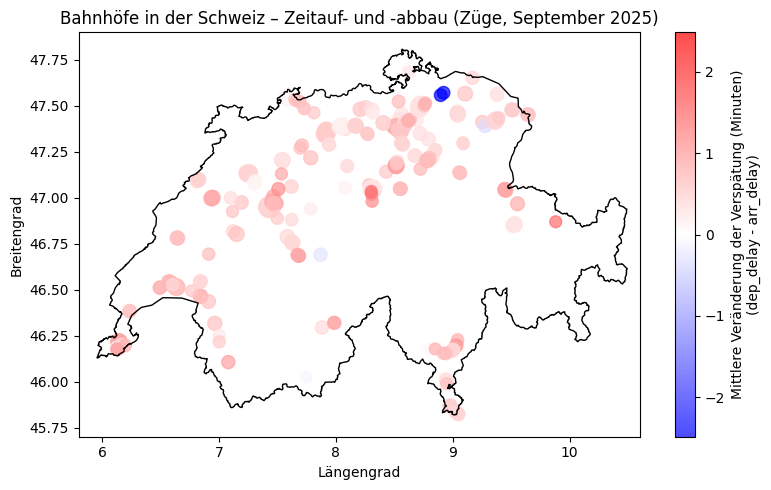

In [51]:
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np

border_path = Path("../data/external/switzerland.geojson")

fig, ax = plt.subplots(figsize=(8, 5))

# 1) Schweiz-Grenze
plot_switzerland_border(
    ax,
    border_path,
    linewidth=1.0,
    color="black",
)

# 2) Farbbereich symmetrisch um 0 wählen,
#    damit blau = Zeit gutmachen, rot = Verspätung
vals = stations_geo["mean_delta_delay_min"]
max_abs = np.nanmax(np.abs(vals))

# 3) Stationen mit blau–weiß–rot einfärben
sc = ax.scatter(
    stations_geo["lon"],
    stations_geo["lat"],
    c=vals,
    cmap="bwr",          # blau–weiß–rot
    vmin=-max_abs,       # symmetrisch um 0
    vmax= max_abs,
    s=stations_geo["n_obs"] ** 0.5,
    alpha=0.7,
)

cb = plt.colorbar(
    sc,
    ax=ax,
    label="Mittlere Veränderung der Verspätung (Minuten)\n(dep_delay - arr_delay)",
)

ax.set_xlabel("Längengrad")
ax.set_ylabel("Breitengrad")
ax.set_title("Bahnhöfe in der Schweiz – Zeitauf- und -abbau (Züge, September 2025)")

# Feste, sinnvolle Schweiz-Bounding-Box
ax.set_xlim(5.8, 10.6)
ax.set_ylim(45.7, 47.9)

plt.tight_layout()
plt.show()